In [12]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [13]:
import sys
sys.path.insert(0,'vp_class/')

In [14]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

In [15]:
import pickle

with open('EX03_DW-SDE', 'rb') as f:
    true_sde_pts = pickle.load(f)
    true_sde_trj = pickle.load(f)
    obs = pickle.load(f)
    obs_time = pickle.load(f)
    obs_sigma = pickle.load(f)
    sde_sigma = pickle.load(f)

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.01 and 0.8 repectively.

1. Simulate sample path from the prior process, i.e. double-well system SDE

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

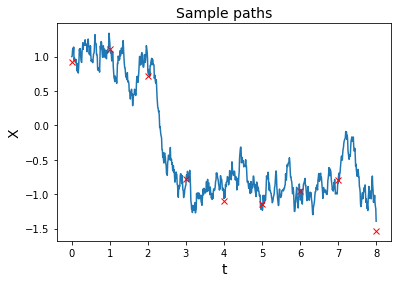

In [16]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + \sigma dW_t$$

$$\log\exp{\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}}^{t_{1}}\frac{4Z_{t}(1-Z^{2}_{t}) + r(Z_{t}-m(t))-m'(t)}{\sigma^{2}}dZ_{t} - \frac{1}{2}\int_{t_{0}}^{t_{1}}\frac{16Z^{2}_{t}(1-Z^{2}_{t})^{2} - (-r(Z_{t} - m(t)) + m'(t))^{2}}{\sigma^{2}}dt$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

Please note that $E(Z_t) = m(t)$. Different from previous notebook, we consider a $\textbf{non-linear mean function}$, allowing $\beta$ to change, which results in $m(t) = \alpha (t + 1)^{\beta} + m_{0}$. Our variational parameters, thus, include $r, \alpha, m_{0}, \beta$

In [17]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
            
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        
#         func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
#                 - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
#                 + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
#                                                                                 alpha * beta * B(s, beta-1))
        def integral(s, z):
            return (16 * z * z * (1 - z * z) ** 2) - ((-r * (z - m(s)) + m_(s)) ** 2)
    
        num = integral(t, self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1) / (sigma * sigma)
#         return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = alpha.shape[0]
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)

        t0 = t[:, 0]
        t1 = t[:, -1]
        
                
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        def B(s, beta):
            return (s+1) ** beta
        
#         def A(s, u):
#             return (-1 * (u ** 4) + 0.5 * (4+r) * (u ** 2) - u * r * (alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
        def A(s, u):
            return (-1 * u ** 4 + 0.5 * (4 + r) * u * u - (r * m(s) + m_(s)) * u) / (sigma * sigma)
                
        def integral_01(t0, t1):
            return r * alpha * (B(t1, beta) - B(t0, beta)) + alpha * beta * (B(t1, beta-1) - B(t0, beta-1))
        
        return A(t1, z1) - A(t0, z0) + integral_01(t0, t1) / (sigma * sigma) - 0.5 * (4 + r) * (t1 - t0) + 6 * torch.trapezoid(self.ou.trj ** 2, x=t)
#         return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [18]:
import tqdm as tq

In [38]:
D = 50
S = 100
learning_rate = 0.00001
lr = learning_rate
IT = 700
dN = 200
z0 = obs[0]


vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((4, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1) + 3.
    if t > 1:
        r_ = torch.tensor([2.])
    beta_ = torch.tensor([1.])
    m0_ = torch.randn(1) + obs[t].clone().detach()
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * gradient['m0'])
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
        beta_grad = torch.nanmean(f_of_X * gradient['beta'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        beta_ -= learning_rate * beta_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()
        pars_traces[3, t, i] = beta_.clone()
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy(), "beta = ", beta_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_.repeat(S,1), sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_85038/906047145.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma = torch.tensor(ou.sigma)


alpha =  [0.00038974] m0 =  [0.78721786] r =  [3.6342065] beta =  [1.]
(Neg) elbo =  7.078947283245816
alpha =  [0.01237375] m0 =  [0.79718152] r =  [3.6353133] beta =  [1.0001059]
(Neg) elbo =  8.486047322776907
alpha =  [0.02301792] m0 =  [0.80642073] r =  [3.6364052] beta =  [1.0003704]
(Neg) elbo =  7.753614303921652
alpha =  [0.03054032] m0 =  [0.81189145] r =  [3.6374192] beta =  [1.0006595]
(Neg) elbo =  5.617332447994152
alpha =  [0.03990865] m0 =  [0.81930051] r =  [3.6386142] beta =  [1.0011278]
(Neg) elbo =  5.919368960310602
alpha =  [0.0471036] m0 =  [0.82379868] r =  [3.639694] beta =  [1.0015855]
(Neg) elbo =  8.61049386035241
alpha =  [0.05350626] m0 =  [0.82775132] r =  [3.6406937] beta =  [1.0020577]
(Neg) elbo =  6.5484016931638
alpha =  [0.05811715] m0 =  [0.83010768] r =  [3.6418245] beta =  [1.0024418]
(Neg) elbo =  7.845910332292824
alpha =  [0.0616736] m0 =  [0.83130343] r =  [3.6430612] beta =  [1.0027676]
(Neg) elbo =  6.322199496354742
alpha =  [0.06781264] m

 12%|█████▋                                       | 1/8 [00:33<03:55, 33.69s/it]

alpha =  [-0.01031306] m0 =  [2.10785035] r =  [3.4988825] beta =  [1.]
(Neg) elbo =  545.7808624497858
alpha =  [-0.2879057] m0 =  [1.76815158] r =  [3.4854224] beta =  [1.0519533]
(Neg) elbo =  87.26692920918163
alpha =  [-0.39616132] m0 =  [1.64266198] r =  [3.484263] beta =  [1.0977993]
(Neg) elbo =  31.428682144231605
alpha =  [-0.4587244] m0 =  [1.57332233] r =  [3.4847274] beta =  [1.130171]
(Neg) elbo =  25.254515414700762
alpha =  [-0.49610955] m0 =  [1.53314519] r =  [3.4855316] beta =  [1.1514008]
(Neg) elbo =  10.997061460070592
alpha =  [-0.52420425] m0 =  [1.50189087] r =  [3.4862058] beta =  [1.168062]
(Neg) elbo =  8.330888769940461
alpha =  [-0.54269856] m0 =  [1.47953375] r =  [3.487014] beta =  [1.179157]
(Neg) elbo =  8.469428335935914
alpha =  [-0.55437165] m0 =  [1.46490619] r =  [3.487823] beta =  [1.1861994]
(Neg) elbo =  6.862664464857631
alpha =  [-0.5643592] m0 =  [1.45186253] r =  [3.488797] beta =  [1.1922361]
(Neg) elbo =  5.462060765575983
alpha =  [-0.57

 25%|███████████▎                                 | 2/8 [01:07<03:21, 33.62s/it]

alpha =  [-0.0017896] m0 =  [0.90517689] r =  [1.9998856] beta =  [1.]
(Neg) elbo =  138.4676827074702
alpha =  [-0.09232556] m0 =  [0.82457797] r =  [2.0010564] beta =  [1.0057071]
(Neg) elbo =  128.29448984865869
alpha =  [-0.17117485] m0 =  [0.75594333] r =  [2.0015852] beta =  [1.0197983]
(Neg) elbo =  96.13039229717603
alpha =  [-0.23791619] m0 =  [0.70077104] r =  [2.0028374] beta =  [1.0383056]
(Neg) elbo =  74.78377850434917
alpha =  [-0.29626465] m0 =  [0.65446986] r =  [2.002772] beta =  [1.0592637]
(Neg) elbo =  65.22336004200082
alpha =  [-0.35646507] m0 =  [0.60636943] r =  [2.0049598] beta =  [1.0850637]
(Neg) elbo =  62.42847536464112
alpha =  [-0.4059979] m0 =  [0.56925092] r =  [2.0062118] beta =  [1.1097211]
(Neg) elbo =  46.60137079533099
alpha =  [-0.4557973] m0 =  [0.5325925] r =  [2.0082667] beta =  [1.1371727]
(Neg) elbo =  44.08961653267937
alpha =  [-0.49897054] m0 =  [0.50183966] r =  [2.010096] beta =  [1.1631328]
(Neg) elbo =  40.441001033047364
alpha =  [-0

 38%|████████████████▉                            | 3/8 [01:40<02:47, 33.57s/it]

alpha =  [-0.00087795] m0 =  [0.29801668] r =  [1.9998678] beta =  [1.]
(Neg) elbo =  81.61039275213969
alpha =  [-0.06197485] m0 =  [0.24508226] r =  [1.9940443] beta =  [1.0025957]
(Neg) elbo =  79.06490691539955
alpha =  [-0.11868604] m0 =  [0.19734219] r =  [1.9907578] beta =  [1.0096439]
(Neg) elbo =  81.11785151502387
alpha =  [-0.17377305] m0 =  [0.15057973] r =  [1.9880922] beta =  [1.0206311]
(Neg) elbo =  58.54446901143589
alpha =  [-0.21741973] m0 =  [0.1156012] r =  [1.9856503] beta =  [1.032342]
(Neg) elbo =  51.193621391720136
alpha =  [-0.2584515] m0 =  [0.08175543] r =  [1.9834125] beta =  [1.045468]
(Neg) elbo =  42.392876867804425
alpha =  [-0.30080274] m0 =  [0.04710607] r =  [1.9816475] beta =  [1.0612098]
(Neg) elbo =  33.618924157679
alpha =  [-0.33922112] m0 =  [0.01719344] r =  [1.9809711] beta =  [1.0775065]
(Neg) elbo =  30.674910293317918
alpha =  [-0.3739178] m0 =  [-0.00920182] r =  [1.9807278] beta =  [1.0937586]
(Neg) elbo =  26.9403768585491
alpha =  [-0

 50%|██████████████████████▌                      | 4/8 [02:14<02:14, 33.68s/it]

alpha =  [-0.00128474] m0 =  [0.25682035] r =  [1.9998386] beta =  [1.]
(Neg) elbo =  97.0794382010523
alpha =  [-0.06350634] m0 =  [0.20296979] r =  [1.9924011] beta =  [1.0027304]
(Neg) elbo =  65.88765894449573
alpha =  [-0.1224315] m0 =  [0.1518366] r =  [1.986057] beta =  [1.010204]
(Neg) elbo =  69.93309396495738
alpha =  [-0.17313075] m0 =  [0.10843105] r =  [1.9810287] beta =  [1.0204134]
(Neg) elbo =  47.3174357405466
alpha =  [-0.21871598] m0 =  [0.07119961] r =  [1.9773604] beta =  [1.0325996]
(Neg) elbo =  43.150156914100364
alpha =  [-0.2620972] m0 =  [0.03570146] r =  [1.9745786] beta =  [1.0466385]
(Neg) elbo =  38.73396019240829
alpha =  [-0.3043467] m0 =  [0.00249513] r =  [1.9727463] beta =  [1.0626798]
(Neg) elbo =  35.281687315035796
alpha =  [-0.3378594] m0 =  [-0.02323001] r =  [1.971451] beta =  [1.0769819]
(Neg) elbo =  31.98171824432439
alpha =  [-0.369157] m0 =  [-0.04717285] r =  [1.9700955] beta =  [1.0915024]
(Neg) elbo =  22.443323160849896
alpha =  [-0.39

 62%|████████████████████████████▏                | 5/8 [02:48<01:41, 33.86s/it]

alpha =  [-0.00074492] m0 =  [0.14400389] r =  [1.9999168] beta =  [1.]
(Neg) elbo =  62.09368849959096
alpha =  [-0.0470952] m0 =  [0.10393273] r =  [1.9955037] beta =  [1.0015012]
(Neg) elbo =  56.66647245124959
alpha =  [-0.0927423] m0 =  [0.06529753] r =  [1.9921176] beta =  [1.0058944]
(Neg) elbo =  36.12735797252527
alpha =  [-0.12832014] m0 =  [0.03524704] r =  [1.9888642] beta =  [1.0113094]
(Neg) elbo =  37.45937814986247
alpha =  [-0.16517425] m0 =  [0.00396453] r =  [1.9863324] beta =  [1.0187027]
(Neg) elbo =  27.15278309346306
alpha =  [-0.19938013] m0 =  [-0.02433437] r =  [1.9847208] beta =  [1.0272169]
(Neg) elbo =  29.691038671931885
alpha =  [-0.23101337] m0 =  [-0.05021356] r =  [1.9836742] beta =  [1.0364604]
(Neg) elbo =  24.68291718035246
alpha =  [-0.26025003] m0 =  [-0.07397574] r =  [1.9832631] beta =  [1.0461355]
(Neg) elbo =  19.656320487178018
alpha =  [-0.28402093] m0 =  [-0.09255011] r =  [1.9828382] beta =  [1.0548646]
(Neg) elbo =  23.22374542343132
alph

 75%|█████████████████████████████████▊           | 6/8 [03:22<01:07, 33.91s/it]

alpha =  [0.00015087] m0 =  [-0.93794938] r =  [2.0000305] beta =  [1.]
(Neg) elbo =  12.696621801894349
alpha =  [0.0183398] m0 =  [-0.92033303] r =  [2.0034933] beta =  [1.0002174]
(Neg) elbo =  12.702487154431857
alpha =  [0.03187132] m0 =  [-0.90644563] r =  [2.006978] beta =  [1.0006601]
(Neg) elbo =  9.36948078314526
alpha =  [0.04341997] m0 =  [-0.89483214] r =  [2.0107358] beta =  [1.0012306]
(Neg) elbo =  11.9300223301216
alpha =  [0.05280618] m0 =  [-0.88482427] r =  [2.0140429] beta =  [1.0018134]
(Neg) elbo =  12.1754524659217
alpha =  [0.06075641] m0 =  [-0.87610883] r =  [2.0178852] beta =  [1.002388]
(Neg) elbo =  4.975159016347899
alpha =  [0.06960484] m0 =  [-0.86678541] r =  [2.021245] beta =  [1.003137]
(Neg) elbo =  8.849730611443118
alpha =  [0.07712608] m0 =  [-0.85902962] r =  [2.023939] beta =  [1.0038567]
(Neg) elbo =  7.261758732727587
alpha =  [0.082676] m0 =  [-0.85258616] r =  [2.0276325] beta =  [1.0044092]
(Neg) elbo =  13.229887549703923
alpha =  [0.0884

 88%|███████████████████████████████████████▍     | 7/8 [03:56<00:33, 33.81s/it]

alpha =  [0.00054403] m0 =  [-1.40466352] r =  [1.9999872] beta =  [1.]
(Neg) elbo =  33.77860622796892
alpha =  [0.03809054] m0 =  [-1.36369673] r =  [2.0025418] beta =  [1.0009048]
(Neg) elbo =  25.24980706036916
alpha =  [0.06778856] m0 =  [-1.33044818] r =  [2.006096] beta =  [1.0028813]
(Neg) elbo =  34.737811568507084
alpha =  [0.08572444] m0 =  [-1.30908801] r =  [2.010931] beta =  [1.0045643]
(Neg) elbo =  34.39128270242578
alpha =  [0.10484818] m0 =  [-1.28570062] r =  [2.017146] beta =  [1.0067536]
(Neg) elbo =  28.47592149133607
alpha =  [0.11193155] m0 =  [-1.27443336] r =  [2.0218852] beta =  [1.0075562]
(Neg) elbo =  28.423313457772853
alpha =  [0.11758683] m0 =  [-1.26486609] r =  [2.027394] beta =  [1.0082135]
(Neg) elbo =  32.745920046788356
alpha =  [0.11882874] m0 =  [-1.25944036] r =  [2.0329676] beta =  [1.0081865]
(Neg) elbo =  27.865442603436748
alpha =  [0.12125431] m0 =  [-1.25270651] r =  [2.0386758] beta =  [1.0083373]
(Neg) elbo =  24.08145442328501
alpha = 

100%|█████████████████████████████████████████████| 8/8 [04:30<00:00, 33.77s/it]


3. Visualize the outcome

Trace plot: ELBO

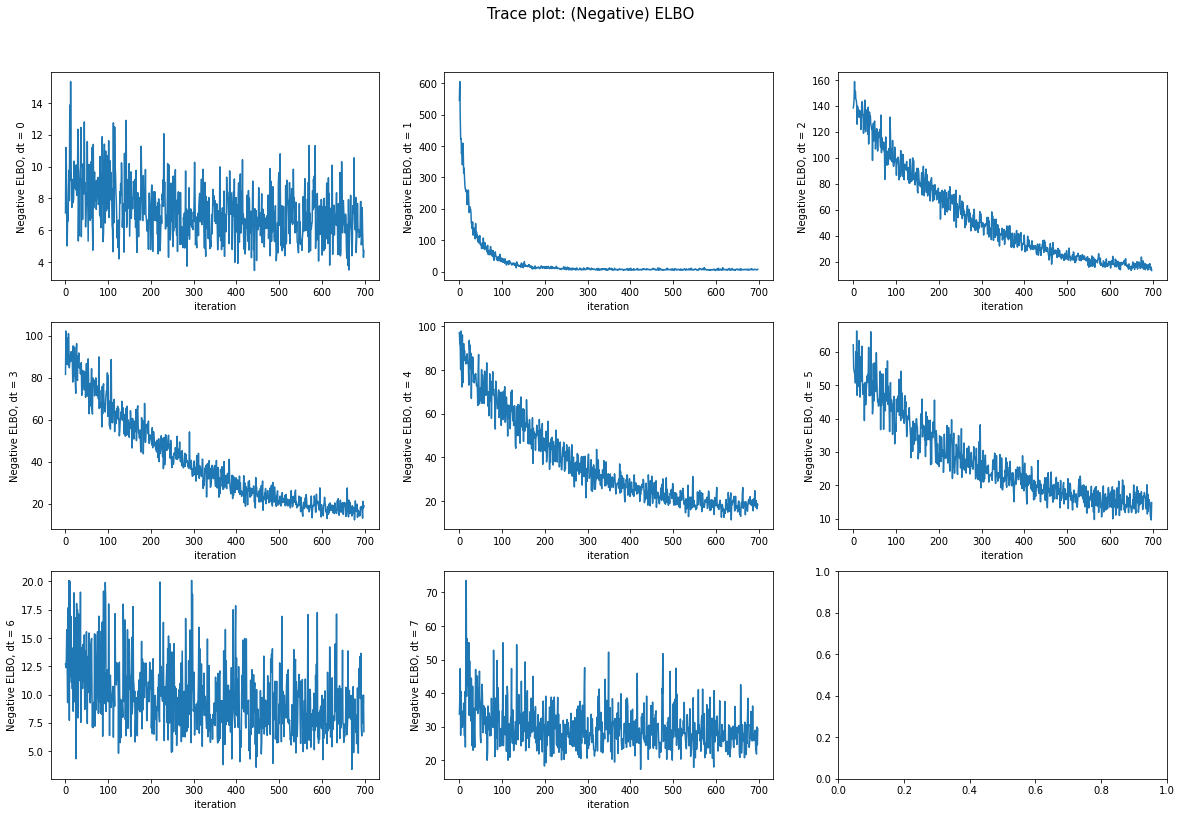

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

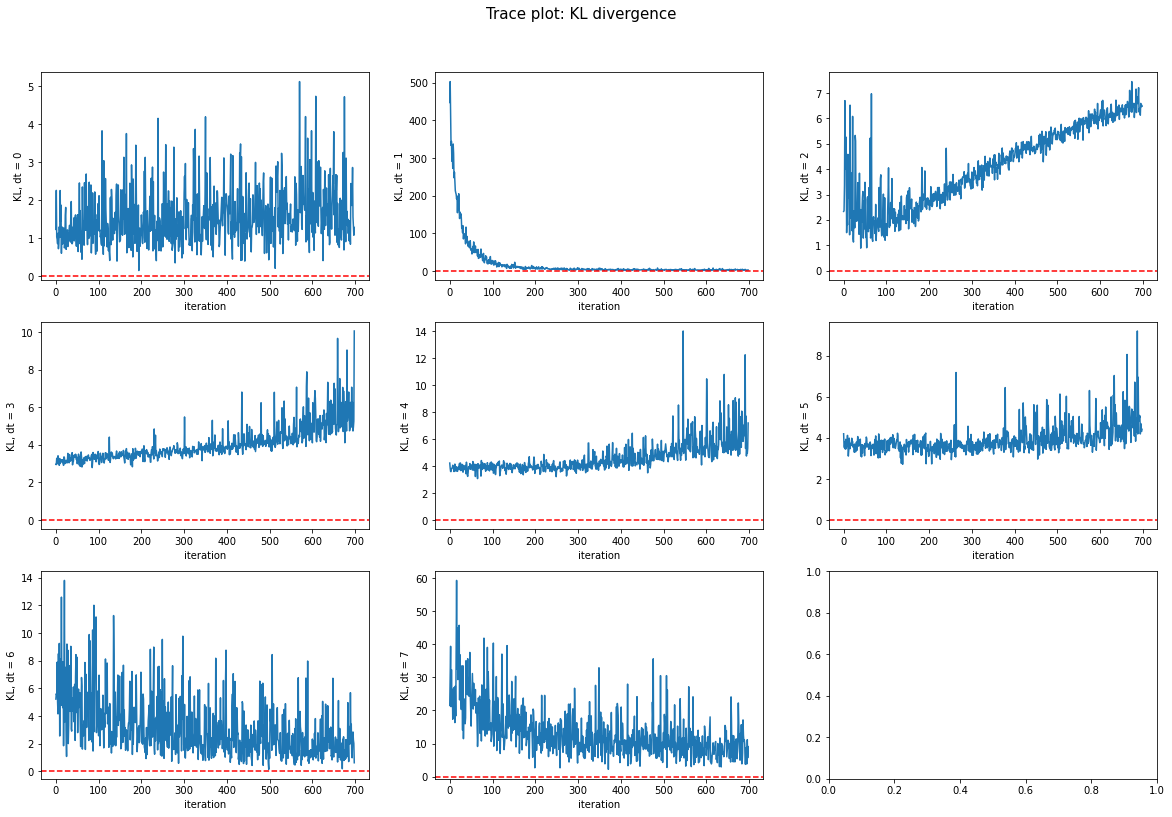

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

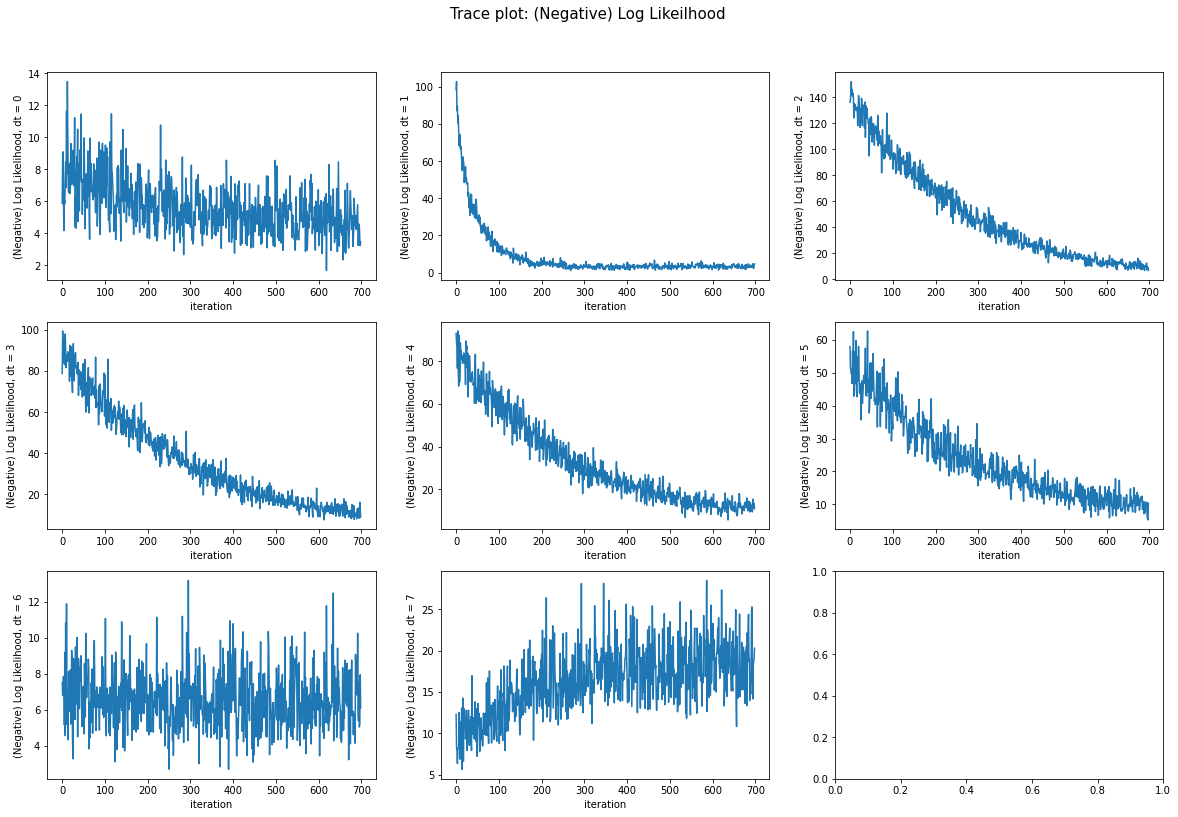

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

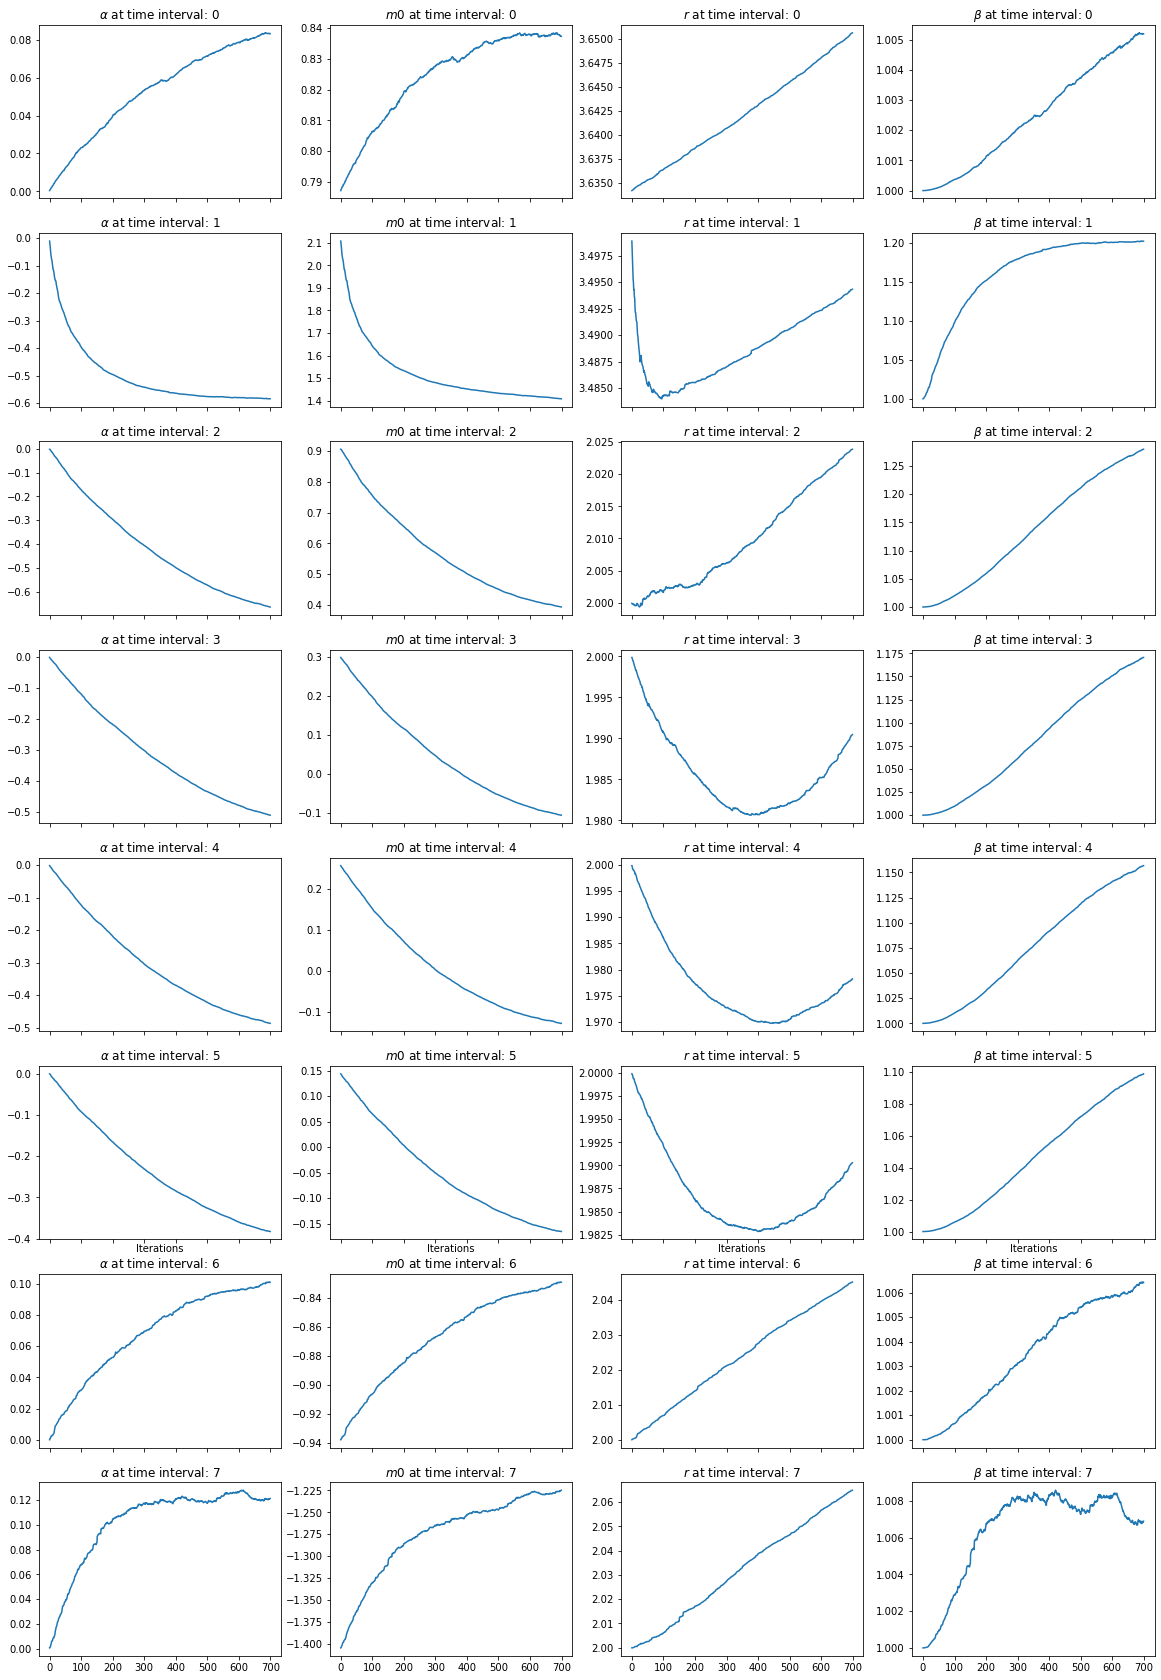

In [42]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=4, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$', r"$\beta$"]
for j, ax in enumerate(ax.ravel()):
    i = j % 4
    t = j // 4
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

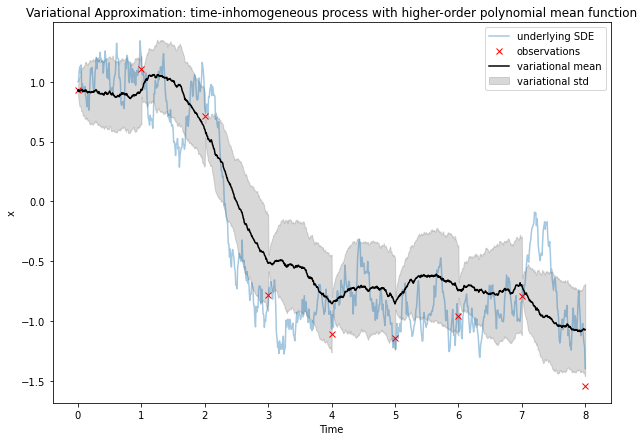

In [43]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with higher-order polynomial mean function")
plt.show()